In [8]:
import glob
import os
import joblib
import yaml
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

In [3]:
config_file = "../results/100/model.yml"

In [6]:
with open(config_file) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [9]:
save_loc = conf["save_loc"]
inf_save_loc = conf["inference"]["data_set"]["name"]
path_to_preds = os.path.join(save_loc, inf_save_loc, "propagated")
distance_threshold = conf["inference"]["distance_threshold"]

In [16]:
load_fn = os.path.join(save_loc, inf_save_loc,
                       f"prediction_table_{str(distance_threshold)}.csv")

In [107]:
prediction_table = pd.read_csv(load_fn)

In [108]:
prediction_table["x_t"] = prediction_table["x_t"] * (2 * 7300 / 4872) - 7300
prediction_table["y_t"] = prediction_table["y_t"] * (2 * 4800 / 3248) - 4800
prediction_table["x_p"] = prediction_table["x_p"] * (2 * 7300 / 4872) - 7300
prediction_table["y_p"] = prediction_table["y_p"] * (2 * 4800 / 3248) - 4800
prediction_table["d_t"] = 2.96 * prediction_table["d_t"] 
prediction_table["d_p"] = 2.96 * prediction_table["d_p"] 

### Create average histogram

In [112]:
bins = {'x': np.arange(-7300,7300, (7300--7300)//19),
        'y': np.arange(-4800,4800, (4800--4800)//19),
        'z': np.arange(14000,158000, (158000-14000)//20),
        'd': np.arange(0,100, (100-0)//18)}

widths = {'x': (7300--7300)//19,
          'y': (4800--4800)//19,
          'z': (158000-14000)//20,
          'd': (100-0)//18}

In [128]:
h_range = prediction_table["h"].unique()

In [130]:
hist_avg = {}
for row in ("_t", "_p"):
    hist_avg[row] = {}
    for coord in ['x', 'y', 'z', 'd']:
        coord_row = coord + row
        hist = []
        for h_idx in h_range:
            c = prediction_table["h"] == h_idx
            h, binEdges = np.histogram(prediction_table[c][coord_row], bins=bins[coord])
            hist.append(h)
        hist_avg[row][coord] = np.stack(hist)
        hist_avg[row][coord+'_mean'] = np.stack(hist).mean(axis=0)
        hist_avg[row][coord+'_std'] = np.stack(hist).std(axis=0) / ((len(h_range) - 1) ** 0.5)

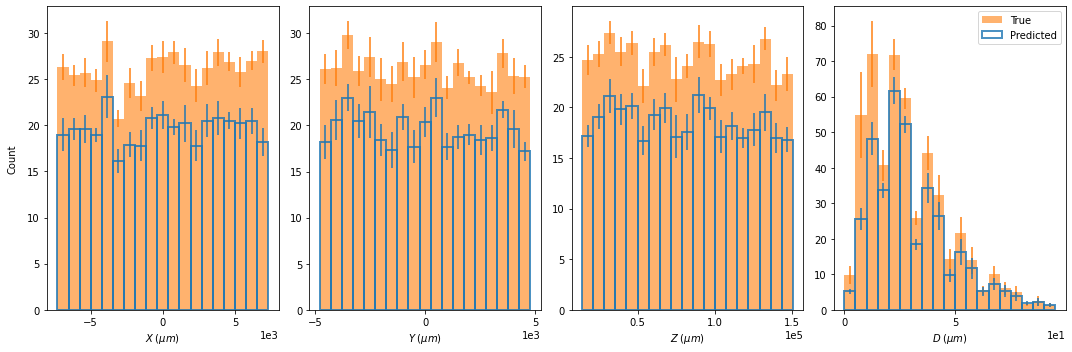

In [124]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharex='col', figsize=(15,5))

for i, coord in enumerate(['x', 'y', 'z', 'd']):
    _, binEdges = np.histogram(hist_avg_manopt["_t"][coord], bins=bins[coord])
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    
    ax[i].bar(bincenters, hist_avg_manopt["_t"][f'{coord}_mean'], alpha=0.6, width=widths[coord], 
                 yerr=hist_avg_manopt['_t'][f'{coord}_std'], 
                 color='#ff7f0e', ecolor='#ff7f0e')
    
    ax[i].bar(bincenters, 
                 hist_avg_manopt['_p'][f'{coord}_mean'], alpha=0.8, width=widths[coord], 
                 yerr=hist_avg_manopt['_p'][f'{coord}_std'], label='Predicted',
            fill=False, linewidth=2, edgecolor='#1f77b4', ecolor='#1f77b4')
    
    ax[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax[i].locator_params(axis='x', nbins=4)
    
cols = ["$X\;({\mu}m)$", "$Y\;({\mu}m)$", "$Z\;({\mu}m)$", "$D\;({\mu}m)$"]
# rows = ["Neural Network", "Standard Method"]

for a, col in zip(ax, cols):
    a.set_xlabel(col)

ax[0].set_ylabel("Count", rotation=90, labelpad=10)
ax[3].legend(["True", "Predicted"])

fig.tight_layout()
fig.show()

### Plot in 3D

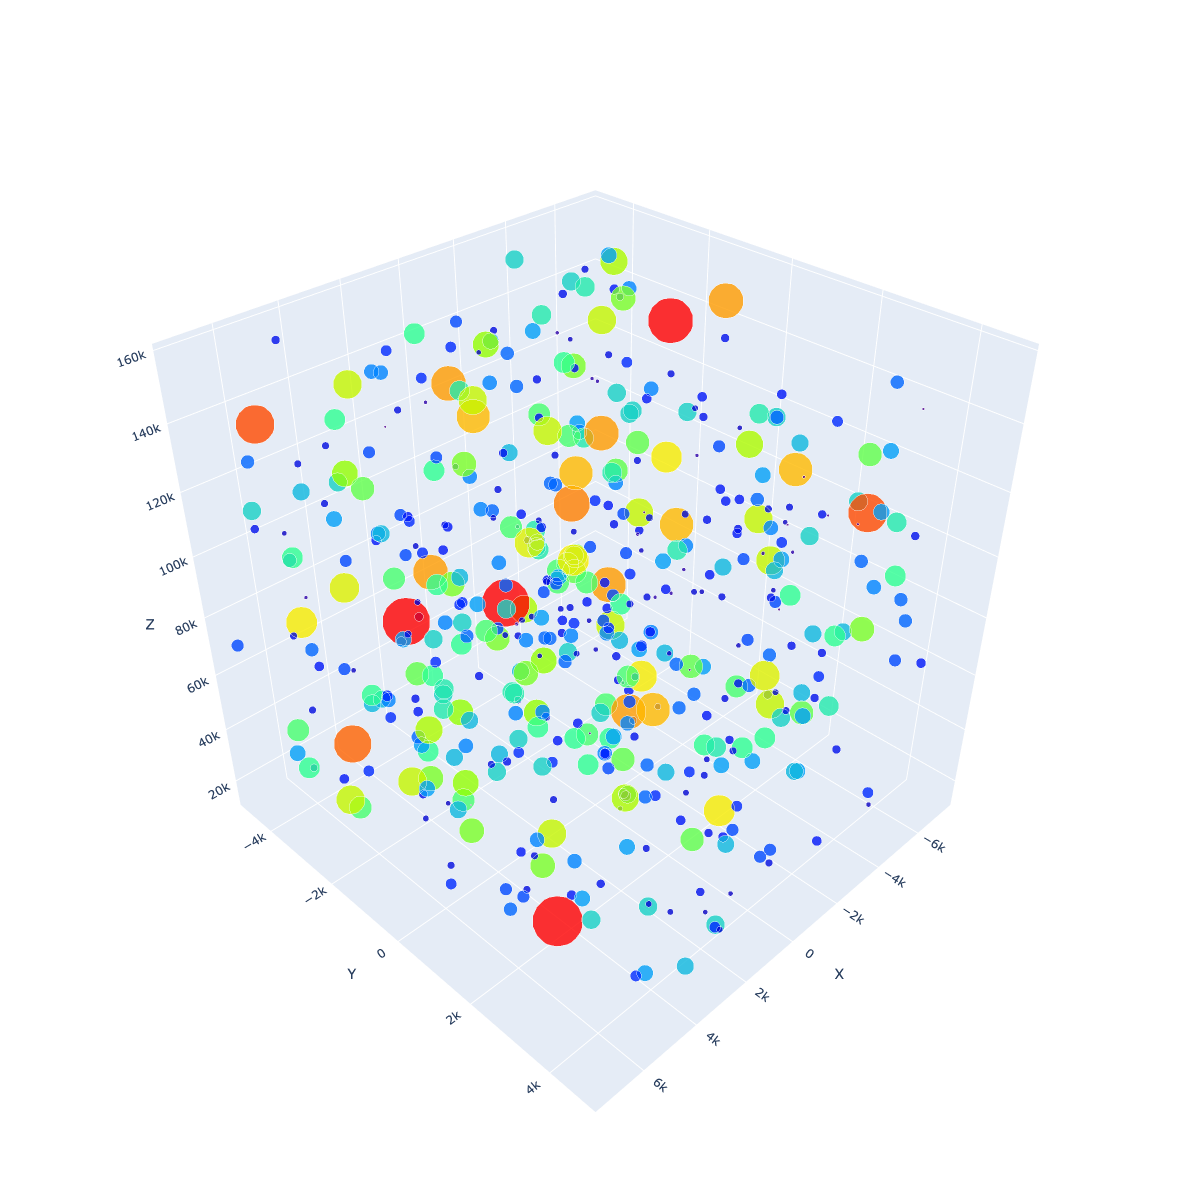

In [131]:
h_idx = 0
c = prediction_table["h"] == h_idx

data = go.Scatter3d(x=prediction_table[c]['x_t'],
                    y=prediction_table[c]['y_t'],
                    z=prediction_table[c]['z_t'],
                    mode='markers',
                    marker=dict(size=prediction_table[c]['d_t']/2,
                                color=prediction_table[c]['d_t'],
                                colorscale='Rainbow',
                                cmin=0,
                                cmax=100,
                                opacity=0.8))

layout = go.Layout(width=1200,
                   height=1200)

fig = go.Figure(data=data, layout=layout)

fig.update_layout(scene=dict(xaxis_title='X',
                             xaxis_tickformat='s',
                             yaxis_title='Y',
                             yaxis_tickformat='s',
                             zaxis_title='Z',
                             zaxis_tickformat='s'),
                  scene_camera=dict(up=dict(x=0, y=0, z=1),
                                    center=dict(x=0, y=0, z=0),
                                    eye=dict(x=1.5, y=1.5, z=1.5)),
                  plot_bgcolor='rgba(0,0,0,0)',
                  paper_bgcolor='rgba(0,0,0,0)',
                  margin=dict(l=0, r=0, t=0, b=0, pad=0))

#fig.write_image(f"paper_figures/3D_{h_idx}_{true}_holosuite.png", format='png')
#fig.write_image(f"paper_figures/3D_{h_idx}_{true}_holosuite.pdf", format='pdf')
fig.show()